# 1A.soft - Notions de SQL - correction

Correction des exercices du premier notebooks relié au SQL.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Recupérer les données

In [3]:
import os
if not os.path.exists("td8_velib.db3"):
    from pyensae import download_data
    download_data("td8_velib.zip", website = 'xd')
    from pyensae.sql import import_flatfile_into_database
    dbf = "td8_velib.db3"
    import_flatfile_into_database(dbf, "td8_velib.txt")                   # 2 secondes 
    import_flatfile_into_database(dbf, "stations.txt", table="stations")  # 2 minutes

In [4]:
%load_ext pyensae

In [5]:
%SQL_connect td8_velib.db3

## Exercice 1

In [6]:
%%SQL
SELECT COUNT(*) FROM (
    SELECT DISTINCT last_update FROM td8_velib
) ;

,COUNT(*)
0,15294


In [7]:
%%SQL
SELECT MIN(last_update), MAX(last_update) FROM td8_velib ;

,MIN(last_update),MAX(last_update)
0,2013-07-22 09:00:19,2013-09-13 11:25:19


## Exercice 2

In [8]:
%%SQL
SELECT number, COUNT(*) AS nb 
FROM td8_velib
WHERE available_bikes==0 AND last_update >= '2013-09-10 11:30:19'
GROUP BY number
ORDER BY nb DESC

,number,nb
0,7025,864
1,12124,864
2,15025,864
3,15108,864
4,16135,864
5,18023,864
6,18037,864
7,18048,864
8,18049,864
9,18102,864


## Exercice 3 : plage horaires de cinq minutes où il n'y a aucun vélo disponible

In [9]:
%%SQL
SELECT nb, COUNT(*) AS nb_station
FROM (
  -- requête de l'exercice précédent
  SELECT number, COUNT(*) AS nb 
  FROM td8_velib
  WHERE available_bikes==0 AND last_update >= '2013-09-10 11:30:19'
  GROUP BY number
)
GROUP BY nb

,nb,nb_station
0,1,7
1,2,7
2,3,5
3,4,6
4,5,6
5,6,5
6,7,8
7,8,9
8,9,1
9,10,7


## Exercice 4 : distribution horaire par station et par tranche de 5 minutes

In [10]:
%%SQL
SELECT A.number, A.heure, A.minute, 1.0 * A.nb_velo / B.nb_velo_tot  AS distribution_temporelle
FROM (
  SELECT number, heure, minute, SUM(available_bikes) AS nb_velo
  FROM td8_velib
  WHERE last_update >= '2013-09-10 11:30:19'
  GROUP BY heure, minute, number
) AS A
JOIN (
  SELECT number, heure, minute, SUM(available_bikes) AS nb_velo_tot
  FROM td8_velib
  WHERE last_update >= '2013-09-10 11:30:19'
  GROUP BY number
) AS B
ON A.number == B.number
--WHERE A.number in (8001, 8003, 15024, 15031)  -- pour n'afficher que quelques stations
ORDER BY A.number, A.heure, A.minute

,number,heure,minute,distribution_temporelle
0,901,0,0,0.001104
1,901,0,5,0.001104
2,901,0,10,0.001104
3,901,0,15,0.001104
4,901,0,20,0.001104
5,901,0,25,0.000946
6,901,0,30,0.000946
7,901,0,35,0.000946
8,901,0,40,0.000946
9,901,0,45,0.000946


## Zones de travail et zones de résidence

In [11]:
%%SQL --df=df
SELECT number, SUM(distribution_temporelle) AS velo_jour
FROM (
  -- requête de l'exercice 4
    SELECT A.number, A.heure, A.minute, 1.0 * A.nb_velo / B.nb_velo_tot  AS distribution_temporelle
    FROM (
        SELECT number, heure, minute, SUM(available_bikes) AS nb_velo
        FROM td8_velib
        WHERE last_update >= '2013-09-10 11:30:19'
        GROUP BY heure, minute, number
    ) AS A
    JOIN (
        SELECT number, heure, minute, SUM(available_bikes) AS nb_velo_tot
        FROM td8_velib
        WHERE last_update >= '2013-09-10 11:30:19'
        GROUP BY number
    ) AS B
    ON A.number == B.number
)
WHERE heure >= 10 AND heure <= 16 
GROUP BY number

,number,velo_jour
0,901,0.555188
1,903,0.473137
2,904,0.357640
3,905,0.323395
4,906,0.117566
5,908,0.501727
6,1001,0.486796
7,1002,0.355434
8,1003,0.364749
9,1004,0.440549


In [12]:
df = df.sort_values("velo_jour").reset_index()
df["index"] = range(0, df.shape[0])
df.head()

,index,number,velo_jour
0,0,18113,0.000000
1,1,35013,0.000000
2,2,10010,0.000000
3,3,20037,0.007382
4,4,20119,0.010623


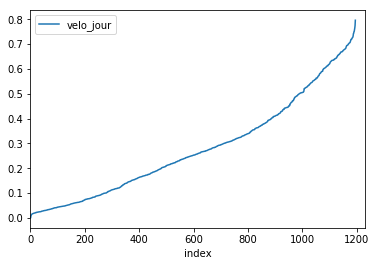

In [13]:
df.plot(x="index", y="velo_jour")

## JOIN avec la table stations et les stations "travail"

On trouve les arrondissements où les stations de vélib sont les plus remplies en journée au centre de Paris.

In [14]:
%%SQL
SELECT C.number, name, lat, lng, velo_jour FROM 
(
  -- requête de la partie précédente
    SELECT number, SUM(distribution_temporelle) AS velo_jour
    FROM (
        -- requête de l'exercice 4
        SELECT A.number, A.heure, A.minute, 1.0 * A.nb_velo / B.nb_velo_tot  AS distribution_temporelle
        FROM (
            SELECT number, heure, minute, SUM(available_bikes) AS nb_velo
            FROM td8_velib
            WHERE last_update >= '2013-09-10 11:30:19'
            GROUP BY heure, minute, number
        ) AS A
        JOIN (
            SELECT number, heure, minute, SUM(available_bikes) AS nb_velo_tot
            FROM td8_velib
            WHERE last_update >= '2013-09-10 11:30:19'
            GROUP BY number
        ) AS B
        ON A.number == B.number
    )
    WHERE heure >= 10 AND heure <= 16 
    GROUP BY number
) AS C
INNER JOIN stations
ON C.number == stations.number 

,number,name,lat,lng,velo_jour
0,901,00901 - PORT SOLFÉRINO (STATION MOBILE),48.861380,2.324420,0.555188
1,903,00903 - QUAI MAURIAC / PONT DE BERCY,48.837134,2.374341,0.473137
2,904,00904 - PLACE JOFFRE / ECOLE MILITAIRE,48.852136,2.301961,0.357640
3,905,00905 - CONCORDE/BERGES DE SEINE (STATION MOBILE),48.863140,2.316690,0.323395
4,906,00906 - GARE DE L'EST,48.876420,2.358630,0.117566
5,908,00908 - PORT DU GROS CAILLOU (STATION MOBILE),48.862880,2.306520,0.501727
6,1001,01001 - ILE DE LA CITE PONT NEUF,48.857092,2.341748,0.486796
7,1002,01002 - PLACE DU CHATELET,48.857940,2.347010,0.355434
8,1003,01003 - RIVOLI SAINT DENIS,48.859150,2.347620,0.364749
9,1004,01004 - MARGUERITE DE NAVARRE,48.859896,2.346757,0.440549
